### Libraries

In [11]:
import os
import numpy as np
import random
import tensorflow as tf
import matplotlib.pyplot as plt
import datetime
import pandas as pd
import re
import collections
import string
import math
from tensorflow.contrib import learn
import io
%matplotlib inline

### Read data

In [2]:
filename = './train.csv'
train_data = pd.read_csv(filename)
print ('Data size:', len(train_data))
train_data.head()

Data size: 3947


,Insult,Date,Comment
0,1,20120618192155Z,"""You fuck your dad."""
1,0,20120528192215Z,"""i really don't understand your point.\xa0 It ..."
2,0,NaN,"""A\\xc2\\xa0majority of Canadians can and has ..."
3,0,NaN,"""listen if you dont wanna get married to a man..."
4,0,20120619094753Z,"""C\xe1c b\u1ea1n xu\u1ed1ng \u0111\u01b0\u1edd..."


In [3]:
filename = './test_with_solutions.csv'
valid_data = pd.read_csv(filename)
print ('Data size:', len(valid_data))
valid_data.head()

Data size: 2647


,Insult,Date,Comment,Usage
0,0,NaN,"""THE DRUDGE REPORT\\n\\n\\n\\nYou won't see th...",PublicTest
1,0,20120618222256Z,"""@ian21\xa0""Roger Clemens is the fucking man, ...",PublicTest
2,1,20120618213617Z,"""Agree with Alan you are an extremest idiot. ...",PublicTest
3,0,NaN,"""Really?\\n\\nI see Marc Lamont Hill on variou...",PrivateTest
4,0,20120620003825Z,"""Really suck isn't the word, when many of our ...",PrivateTest


### Data preprocessing

In [4]:
def data_preprocessing(data):
    max_sym_len = 0
    max_word_len = 0
    lens_in_words = []

    for i, comment in enumerate(data['Comment']):
        data.iloc[i,2] = data.iloc[i,2].lower()
        data.iloc[i,2] = re.sub('n\'t', ' not', data.iloc[i,2])
        data.iloc[i,2] = re.sub('\'m', ' ', data.iloc[i,2])
        data.iloc[i,2] = re.sub('\'s', ' ', data.iloc[i,2])
        data.iloc[i,2] = re.sub('\'re', ' ', data.iloc[i,2])
        data.iloc[i,2] = re.sub('\'ve', ' ', data.iloc[i,2])
        data.iloc[i,2] = re.sub('\'d', ' ', data.iloc[i,2])
        data.iloc[i,2] = re.sub(' im ', ' i', data.iloc[i,2])
        data.iloc[i,2] = re.sub(' ur ', ' you ', data.iloc[i,2])
        data.iloc[i,2] = re.sub('\? ', ' ', data.iloc[i,2])
        data.iloc[i,2] = re.sub('[!?]+', ' mysignssymbol ', data.iloc[i,2])
        data.iloc[i,2] = re.sub(r'href=[\'"]?([^\'" >]+)', ' ', data.iloc[i,2])
        data.iloc[i,2] = re.sub('[^a-z]+', ' ', data.iloc[i,2]) # replace everything not lowercase literals with space
        data.iloc[i,2] = re.sub('\s+', ' ',  data.iloc[i,2] ).strip() #replace multiple spaces
        for letter in string.ascii_lowercase: #replace multiple letters (3 and more) 
            data.iloc[i,2] = re.sub(letter * 3 + '+', letter,  data.iloc[i,2] ).strip() 
        data.iloc[i,2] = re.sub('mysignssymbol', '<SIGNS>', data.iloc[i,2])
        data.iloc[i,2] = re.sub('\s+', ' ',  data.iloc[i,2] ).strip() #replace multiple spaces
        if max_sym_len < len(comment):
            max_sym_len = len(comment)
        if max_word_len < len(comment.split(' ')):
            max_word_len = len(comment.split(' '))
        lens_in_words.append(len(comment.split(' ')))
        
    print ('Max comment length in symbols:', max_sym_len)
    print ('Max comment length in words:  ', max_word_len)
    plt.plot(np.arange(len(lens_in_words)), np.asarray(lens_in_words))
    plt.xlabel('Comment')
    plt.ylabel('Length in words')
    return data

Max comment length in symbols: 17805
Max comment length in words:   2407
Max comment length in symbols: 20030
Max comment length in words:   1419


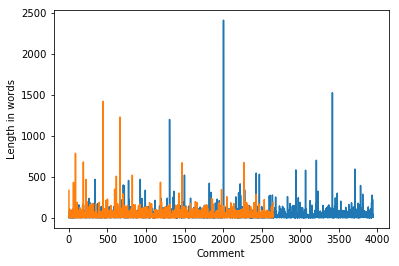

In [5]:
train_data = data_preprocessing(train_data)
valid_data = data_preprocessing(valid_data)
valid_size = len(valid_data)
train_size = len(train_data)

X_train = train_data['Comment']
y_train = train_data['Insult']
X_valid = valid_data['Comment']
y_valid = valid_data['Insult']

### Load pretrained vocabulary

In [24]:
def loadGloVe(filename):
    vocab = []
    embd = []
    file = io.open(filename,'r' , encoding='utf-8')
    for line in file.readlines():
        row = line.strip().split(' ')
        vocab.append(row[0])
        embd.append(row[1:])
    print('Loaded GloVe!')
    file.close()
    return vocab,embd


vocabulary, embedding_ = loadGloVe('./glove.6B/glove.6B.50d.txt')
vocabulary_size = len(vocabulary)
embedding_size = len(embedding_[0])
embedding = np.asarray(embedding_)

print ('Vocabulary size:', vocabulary_size)
print ('Embedding size: ', embedding_size)

Loaded GloVe!
Vocabulary size: 400000
Embedding size:  50


### Generation of batches

In [25]:
class LabeledBatchGenerator(object):
    def __init__(self, comments, batch_size, comment_size, labels):
        self._comments = comments
        self._num_comments = len(comments)
        self._batch_size = batch_size
        self._comment_size = comment_size
        self._labels = labels
        segment = self._num_comments // batch_size
        self._cursor = [offset * segment for offset in range(batch_size)]
        
    def _next_batch(self, step):
        batch = np.zeros(shape=(self._batch_size,1), dtype=np.int)
        for b in range(self._batch_size):
            batch[b,0] = self._comments[self._cursor[b]][step]
            if step == self._comment_size - 1:
                self._cursor[b] = (self._cursor[b] + 1) % self._num_comments
        return batch
    
    def next(self):
        batches = []
        batches_labels = [self._labels[self._cursor[b]] for b in range(self._batch_size)]
        for step in range(0, self._comment_size):
            batches.append(self._next_batch(step))
        return batches, batches_labels


In [26]:
comment_size = 100
batch_size = 64
valid_batch_size = 1

vocab_processor = learn.preprocessing.VocabularyProcessor(comment_size)
pretrain = vocab_processor.fit(vocabulary)

X_train_ = np.array(list(vocab_processor.transform(X_train.as_matrix())))
X_valid_ = np.array(list(vocab_processor.transform(X_valid.as_matrix())))

train_batch_generator = LabeledBatchGenerator(X_train_, batch_size, comment_size, y_train.as_matrix())
valid_batch_generator = LabeledBatchGenerator(X_valid_, valid_batch_size, comment_size, y_valid.as_matrix())

In [27]:
def plot_results(losses_, mean_losses_, train_aucs_, valid_aucs_, frequency):
    plt.plot(losses_)
    plt.title('Losses')
    plt.xlabel('Step')
    plt.show()

    plt.plot(frequency * np.arange(1,len(mean_losses_)+1), mean_losses_)
    plt.title('MeanLosses')
    plt.xlabel('Step')
    plt.show()

    plt.plot(train_aucs_, label='Train AUC-ROC')
    plt.plot(frequency * np.arange(1,len(valid_aucs_)+1), valid_aucs_, label='Valid AUC-ROC')
    plt.xlabel('Step')
    plt.title('AUC-ROC')
    plt.legend()
    plt.show()

### Tensorflow graph

In [28]:
patch_size = [3,4,5]
num_filters = 128

graph = tf.Graph()
with graph.as_default():
    tf_W = tf.Variable(tf.constant(0.0, shape=[vocabulary_size, embedding_size]), trainable=False, name="W")
    tf_embedding_placeholder = tf.placeholder(tf.float32, [vocabulary_size, embedding_size])
    tf_embedding_init = tf_W.assign(tf_embedding_placeholder)
    
    tf_keep_prob = tf.placeholder(tf.float32)
    tf_data = list()
    tf_labels = tf.placeholder(tf.float32, shape=[None,1])
    for _ in range(comment_size):
        tf_data.append(tf.placeholder(tf.int32, shape=[None, 1]))  
    tf_inputs = tf.concat(tf_data[:comment_size], axis=1)    
    tf_embedded_inputs = tf.nn.embedding_lookup(tf_W, tf_inputs) # batch_size, comment_size, embed_size

    tf_w0 = tf.Variable(tf.truncated_normal(
            [patch_size[0], embedding_size, num_filters], stddev=0.1))
    tf_w1 = tf.Variable(tf.truncated_normal(
            [patch_size[1], num_filters, num_filters], stddev=0.1))
    
    def multi_layer_cnn(data):
        output = []
        conv = tf.nn.conv1d(data, tf_w0, 1, padding='SAME')
        conv = tf.nn.relu(conv) 
        output.append(conv) #3d
        
        pool = tf.nn.max_pool(tf.expand_dims(data,-1), [1, 1, 2, 1], [1, 1, 1, 1], 'VALID')
        pool = tf.nn.relu(pool)
        pool = tf.squeeze(pool, axis=3)
        output.append(pool)
        output = tf.concat(output, axis=2)
        print (output.shape)
        #hidden = tf.squeeze(hidden,axis=3)
        #print (hidden.shape)
        #conv = tf.nn.conv1d(hidden, tf_w1, 1, padding='SAME')
        #hidden = tf.sigmoid(conv)
        #hidden = tf.expand_dims(hidden, -1)
        #pool = tf.nn.max_pool(hidden, [1, 2, 1, 1], [1, 1, 1, 1], 'VALID')
        #hidden = tf.nn.relu(pool)
        
        shape = output.get_shape().as_list()
        reshape = tf.reshape(output, [-1, shape[1] * shape[2]])
        return tf.layers.dense(inputs=reshape, units=1, activation=None)

    tf_logits = tf.nn.dropout(multi_layer_cnn(tf_embedded_inputs), tf_keep_prob)
    #tf_logits = multi_layer_cnn(tf_embedded_inputs)
    tf_loss = (tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=tf_logits, labels=tf_labels)) )
    tf_global_step = tf.Variable(0, trainable=False)
    tf_learning_rate = tf.train.exponential_decay(0.1, tf_global_step,
                                               1000, 0.9, staircase=True)
    #optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    #train_op = optimizer.minimize(loss, global_step=global_step)
    tf_optimizer = tf.train.AdamOptimizer(tf_learning_rate)
    tf_grads = tf_optimizer.compute_gradients(tf_loss)
    tf_op = tf_optimizer.apply_gradients(tf_grads, global_step=tf_global_step)

    tf_prediction = tf.round(tf.sigmoid(tf_logits))
    tf_auc_roc, tf_update_oper = tf.metrics.auc(tf_labels, tf_prediction)
    
    print('Graph is ready!')

(?, 100, 177)
Graph is ready!


In [29]:
t0 = datetime.datetime.now()
losses = []
train_aucs = []
valid_aucs = []
num_steps = 1001
frequency = 100
mean_losses = []

with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()
    tf.local_variables_initializer().run()
    print('Initialized')
    mean_loss = 0.
    
    for step in range(num_steps):
        batches, labels = train_batch_generator.next()
        feed_dict = dict()
        for i in range(comment_size):
            feed_dict[tf_data[i]] = batches[i]
        train_labels_ = np.asarray(labels).astype('float').reshape(-1,1)
        feed_dict[tf_labels] = train_labels_
        feed_dict[tf_keep_prob] = 1.
        feed_dict[tf_embedding_placeholder] = embedding
        l, update, auc, predictions, _ = session.run([tf_loss, tf_update_oper, tf_auc_roc,
                                                   tf_prediction, tf_op],
                                                  feed_dict=feed_dict)
        mean_loss += l
        losses.append(l)
        train_aucs.append(auc)
        if step % frequency == 0 and step > 0:
            mean_loss /= frequency
            print ('\nStep %d' % step)
            print ('True:',np.asarray(labels).astype('int'))
            print ('Pred:',predictions.astype('int').reshape(-1))
            print ('Train loss: %.5f' % mean_loss)
            print ('Train batch AUC-ROC: %.5f ' % auc)
            mean_losses.append(mean_loss)
            mean_loss = 0.
            valid_predictions = []
            valid_true = []
            for _ in range(valid_size):
                valid_b, valid_lab = valid_batch_generator.next()
                feed_dict = dict()
                for i in range(comment_size):
                    feed_dict[tf_data[i]] = valid_b[i]
                feed_dict[tf_labels] = np.asarray(valid_lab).astype('float').reshape(-1,1)
                feed_dict[tf_keep_prob] = 1.
                feed_dict[tf_embedding_placeholder] = embedding
                valid_pred, valid_auc, valid_update = session.run([tf_prediction, tf_auc_roc, tf_update_oper], 
                                                                  feed_dict=feed_dict)
                valid_true.append(valid_lab[0])
                valid_predictions.append(valid_pred[0])
            print('Valid true:     ', np.asarray(valid_true)[:100])
            print('Valid predicted:', np.asarray(valid_predictions).astype('int').reshape(-1)[:100])
            print('Validation AUC-ROC:  %.5f' % valid_auc)
            valid_aucs.append(valid_auc)
t1 = datetime.datetime.now()
print ('TIME:', t1 - t0)

Initialized


KeyboardInterrupt: 

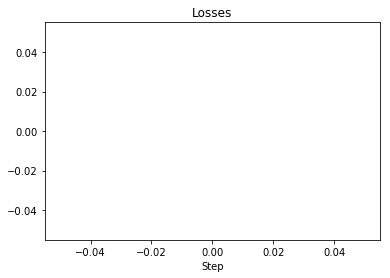

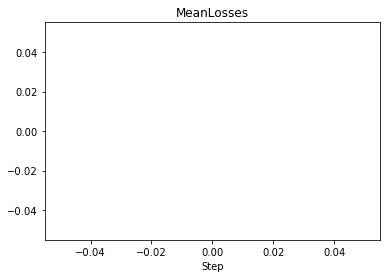

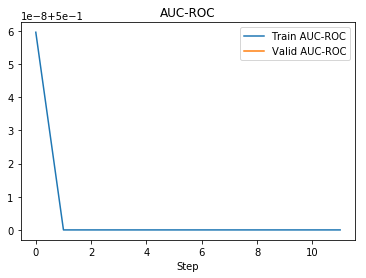

In [30]:
plot_results(losses[20:], mean_losses, train_aucs[1:], valid_aucs, frequency)

# Testing

### Read data

In [ ]:
filename = './test.csv'
test_data = pd.read_csv(filename)
print ('Data size:', len(test_data))
test_data.head()

In [ ]:
test_data = data_preprocessing(test_data)
test_size = len(test_data)

X_test = test_data['Comment']